# Inferring the Lyapunov Function using Post-Processing Zubov's Method 

In this notebook we test our theory of inferring the Lyapunov function as well as the domain of attraction only from the state trajectory data and the structral information of the system operators. We propose a new algorithm emanating from the well-known Zubov Method in nonlinear control theory to infer the two for gauge the stability of the reduced operators constructed using the operator inference approach. This notebook presents the analysis using the energy-preserved Burgers' equation also used in [Notebook 06](06_ep-burgers_EP-OpInf.ipynb).

## Initial Setup

In [1]:
using Distributions
using LaTeXStrings
using LinearAlgebra
using MatrixEquations
using Plots
using ProgressMeter
using Random
using SparseArrays
using Optim

In [2]:
include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn
;

In [3]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.10, 0.10],
    2^(-7), 1e-4, 1, "periodic"
)
;

In [4]:
# Minimum and maximum dimensions
rmin = 1
rmax = 10

burger_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
burger_vars = LnL.vars(
    N=1,
)
burger_data = LnL.data(
    Δt=1e-4,
    DS=100,
)
burger_optim = LnL.opt_settings(
    verbose=true,
    initial_guess=true,
    max_iter=1000,
    reproject=false,
    SIGE=false,
    linear_solver="ma97",
)

options = LnL.LS_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
)

# Downsampling rate
DS = options.data.DS

Tdim_ds = size(1:DS:burger.Tdim, 1)  # downsampled time dimension
;

## Initial Condition for Training

For the training, we will only use one initial condition. However, when we verify the domain of attraction, we will use different initial conditions.

A combination of exponential and cosine initial condition:

$$
\begin{gather*}
    x(\omega, 0) = \exp(-a\cos^2(\pi x+b)) - c
\end{gather*}
$$

where $a, b, c$ are the three parameters to adjust.

In [5]:
# Parameters for the initial condition
IC = Dict(
    :a => [2, 4, 6],
    :b => [-0.5, 0, 0.5],
    :c => [-0.25, 0, 0.25],
    :test => ([0.1, 8], [-0.8, 0.8], [-0.5, 0.5]),
)
IC[:num] = Int(length(IC[:a])*length(IC[:b])*length(IC[:c]))
IC[:func] = (a,b,c) -> exp.(-a * cos.(π .* burger.x .+ b).^2) .- c
;

### Generate Training Data

In [6]:
@info "Generate the FOM system matrices and training data."
μ = burger.μs
    
# Generate the FOM system matrices 
A, F = burger.generateEPmatrix(burger, μ)
op_fom = LnL.operators(A=A, F=F)
states_fom = burger.semiImplicitEuler(A, F, burger.t, burger.IC)
    
## training data for OpInf
Xall = Vector{Matrix{Float64}}(undef, IC[:num])
Xdotall = Vector{Matrix{Float64}}(undef, IC[:num])

ct = 1
for a in IC[:a], b in IC[:b], c in IC[:c]
    states = burger.semiImplicitEuler(A, F, burger.t, IC[:func](a, b, c))
    tmp = states[:, 2:end]
    Xall[ct] = tmp[:, 1:DS:end]  # downsample data
    tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
    Xdotall[ct] = tmp[:, 1:DS:end]  # downsample data
    
    @info "(Loop #$ct) Generated training data for a = $a, b = $b, c = $c"
    ct += 1
end
X = reduce(hcat, Xall)
R = reduce(hcat, Xdotall)

# Compute the POD basis from the training data
tmp = svd(X)
Vrmax = tmp.U[:, 1:rmax]
;

┌ Info: Generate the FOM system matrices and training data.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:1
┌ Info: (Loop #1) Generated training data for a = 2, b = -0.5, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #2) Generated training data for a = 2, b = -0.5, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #3) Generated training data for a = 2, b = -0.5, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #4) Generated training data for a = 2, b = 0.0, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #5) Generated training data for a = 2, b = 0.0, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #6) Generated training data for a = 2, b = 0.0, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #7) Generated training data for a = 2, b = 0.5, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #8) Generated training data for a = 2, b = 0.5, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #9) Generated training data for a = 2, b = 0.5, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #10) Generated training data for a = 4, b = -0.5, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #11) Generated training data for a = 4, b = -0.5, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #12) Generated training data for a = 4, b = -0.5, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #13) Generated training data for a = 4, b = 0.0, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #14) Generated training data for a = 4, b = 0.0, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #15) Generated training data for a = 4, b = 0.0, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #16) Generated training data for a = 4, b = 0.5, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21
┌ Info: (Loop #17) Generated training data for a = 4, b = 0.5, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #18) Generated training data for a = 4, b = 0.5, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21
┌ Info: (Loop #19) Generated training data for a = 6, b = -0.5, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21
┌ Info: (Loop #20) Generated training data for a = 6, b = -0.5, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #21) Generated training data for a = 6, b = -0.5, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #22) Generated training data for a = 6, b = 0.0, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #23) Generated training data for a = 6, b = 0.0, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #24) Generated training data for a = 6, b = 0.0, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #25) Generated training data for a = 6, b = 0.5, c = -0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #26) Generated training data for a = 6, b = 0.5, c = 0.0
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


┌ Info: (Loop #27) Generated training data for a = 6, b = 0.5, c = 0.25
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:21


### Generate Intrusive Operators

In [7]:
@info "Compute the intrusive model"

op_int = LnL.intrusiveMR(op_fom, Vrmax, options)
;

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:1


### Generate OpInf Least-Squares Operators

In [8]:
@info "Compute the Least Squares solution."

op_LS = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options)
;

┌ Info: Compute the Least Squares solution.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_burgers_postprocess-zubov.ipynb:1


## Post-Processed Lyapunov Function Inference (LyapInf) using Zubov's method

In [9]:
P_res = Dict(
    "int"=> Vector{Matrix{Float64}}(undef, rmax-rmin+1),
    "inf"=> Vector{Matrix{Float64}}(undef, rmax-rmin+1)
)
Q_res = Dict(
    "int"=> Vector{Matrix{Float64}}(undef, rmax-rmin+1),
    "inf"=> Vector{Matrix{Float64}}(undef, rmax-rmin+1)
)
Zerr_res = Dict(
    "int"=> Vector{Float64}(undef, rmax-rmin+1),
    "inf"=> Vector{Float64}(undef, rmax-rmin+1)
)
∇Jzubov_res = Dict(
    "int"=> Vector{Float64}(undef, rmax-rmin+1),
    "inf"=> Vector{Float64}(undef, rmax-rmin+1)
)
ρ_max_res = Dict(
    "int"=> Vector{Float64}(undef, rmax-rmin+1),
    "inf"=> Vector{Float64}(undef, rmax-rmin+1)
)
ρ_min_res = Dict(
    "int"=> Vector{Float64}(undef, rmax-rmin+1),
    "inf"=> Vector{Float64}(undef, rmax-rmin+1)
)
ρ_est_res = Dict(
    "int"=> Vector{Float64}(undef, rmax-rmin+1),
    "inf"=> Vector{Float64}(undef, rmax-rmin+1)
)
;

### Analyze Intrusive operators

In [10]:
lyapinf_options = LnL.LyapInf_options(
    extra_iter=3,
    optimizer="ipopt",
    ipopt_linear_solver="ma97",
    verbose=true,
    optimize_both=false,
)

Main.LiftAndLearn.LyapInf_options
  α: Float64 0.0001
  β: Float64 0.0001
  δS: Float64 1.0e-5
  δJ: Float64 1.0e-5
  max_iter: Int64 100
  extra_iter: Int64 3
  optimizer: String "ipopt"
  ipopt_linear_solver: String "ma97"
  verbose: Bool true
  optimize_both: Bool false


In [11]:
for r in rmin:rmax
    i = r - rmin + 1  # index

    A = op_int.A[1:r,1:r]
    F = LnL.extractF(op_int.F, r)
    H = LnL.extractH(op_int.H, r)

    # Solve the PP-ZQLFI problem
    Qinit = 1.0I(r)
    foo = round.(rand(r,r), digits=4)
    Pinit = foo * foo'

    P, Q, Zerr_res["int"][i], ∇Jzubov_res["int"][i] = LnL.PR_Zubov_LFInf(Vrmax[:,1:r]' * X, A, F, Pinit, Qinit, lyapinf_options)
    P_res["int"][i] = P
    Q_res["int"][i] = Q
    
    # Compute the DoA 
    ρ_min_res["int"][i], ρ_max_res["int"][i] = LnL.DoA(P)

    # Compute the estimated domain of attraction from Boris's method
    ρ_est_res["int"][i] = LnL.est_stab_rad(A, H, Q)
end

### Analyze Inferred Operators

In [ ]:
for r in rmin:rmax
    i = r - rmin + 1  # index

    A = op_LS.A[1:r,1:r]
    F = LnL.extractF(op_LS.F, r)
    H = LnL.extractH(op_LS.H, r)

    # Solve the PP-ZQLFI problem
    Q = Matrix(I(r))
    foo = round.(2*rand(r,r), digits=4)
    Pinit = foo * foo'
    P, Zerr_res["inf"][i], ∇Jzubov_res["inf"][i] = LnL.pp_zqlfi(Vrmax[:,1:r]' * X, A, F, Q, Pinit; γ=0.1, max_iter=50, extra_iter=2)
    P_res["inf"][i] = P

    # Compute the DoA 
    ρ_min_res["inf"][i], ρ_max_res["inf"][i] = LnL.DoA(P)

    # Compute the estimated domain of attraction from Boris's method
    ρ_est_res["inf"][i] = LnL.est_stab_rad(A, H, Q)
end

### Plot Results

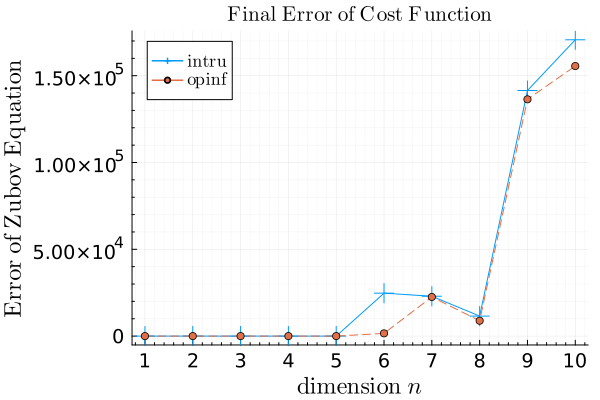

In [12]:
# Final error of cost function
plot(rmin:rmax, Zerr_res["int"], marker=(:cross, 10), label=L"\mathrm{intru}")
plot!(rmin:rmax, Zerr_res["inf"], marker=(:circle), ls=:dash, label=L"\mathrm{opinf}")
plot!(majorgrid=true, minorgrid=true, legend=:best)
xticks!(rmin:rmax)
xlabel!(L"\mathrm{dimension} ~n")
ylabel!(L"\mathrm{Error~of~Zubov~Equation}")
title!(L"\mathrm{Final~Error~of~Cost~Function}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=12)

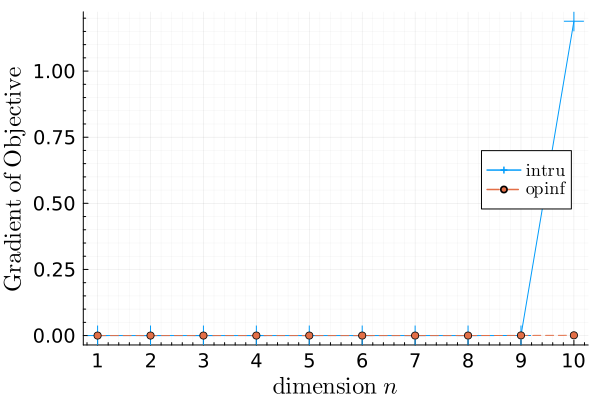

In [13]:
# Final gradient of cost function
plot(rmin:rmax, ∇Jzubov_res["int"], marker=(:cross, 10), label=L"\mathrm{intru}")
plot!(rmin:rmax, ∇Jzubov_res["inf"], marker=(:circle), ls=:dash, label=L"\mathrm{opinf}")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(rmin:rmax)
xlabel!(L"\mathrm{dimension }~n")
ylabel!(L"\mathrm{Gradient~of~Objective}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=12)

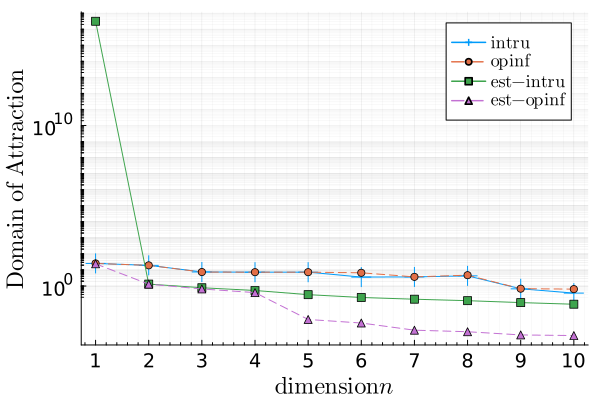

In [14]:
# domain of attraction
plot(rmin:rmax, ρ_min_res["int"], marker=(:cross, 10), label=L"\mathrm{intru}")
plot!(rmin:rmax, ρ_min_res["inf"], marker=(:circle), ls=:dash, label=L"\mathrm{opinf}")
plot!(rmin:rmax, ρ_est_res["int"], marker=(:rect), label=L"\mathrm{est}\rm{-}\mathrm{intru}")
plot!(rmin:rmax, ρ_est_res["inf"], marker=(:utriangle), ls=:dash, label=L"\mathrm{est}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topright)
xticks!(rmin:rmax)
# yticks!([1e-6,1e-4,1e-2,1e-0,1e+2,1e+4,1e+6,1e+8,1e+10,1e+12,1e+14,1e+16])
xlabel!(L"\mathrm{dimension} n")
ylabel!(L"\mathrm{Domain~of~Attraction}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=12)

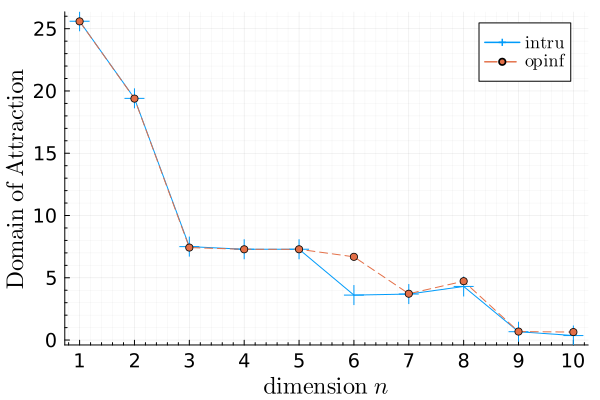

In [18]:
# minimum domain of attraction
plot(rmin:rmax, ρ_min_res["int"], marker=(:cross, 10), label=L"\mathrm{intru}")
plot!(rmin:rmax, ρ_min_res["inf"], marker=(:circle), ls=:dash, label=L"\mathrm{opinf}")
plot!(majorgrid=true, minorgrid=true, legend=:best)
xticks!(rmin:rmax)
xlabel!(L"\mathrm{dimension}~n")
ylabel!(L"\mathrm{Domain~of~Attraction}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=12)

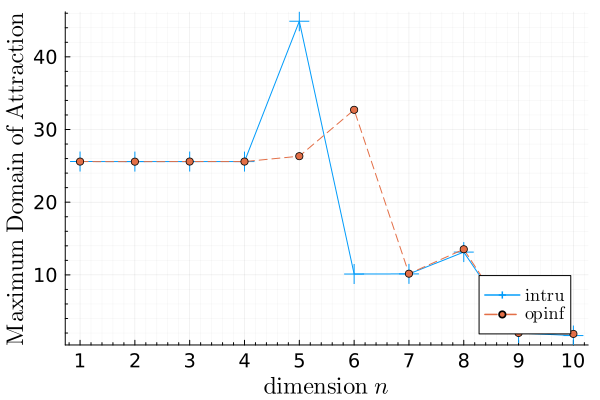

In [19]:
# Maximum domain of attraction
plot(rmin:rmax, ρ_max_res["int"], marker=(:cross, 10), label=L"\mathrm{intru}")
plot!(rmin:rmax, ρ_max_res["inf"], marker=(:circle), ls=:dash, label=L"\mathrm{opinf}")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xticks!(rmin:rmax)
xlabel!(L"\mathrm{dimension}~n")
ylabel!(L"\mathrm{Maximum~Domain~of~Attraction}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=12)

## Verification

In this section, we verify that the Zubov method generates a domain of attraction that is conservative yet accurate enough. We do this by a Monte Carlo approach. We run the reduced model with initial conditions that have a norm in the range of $[\rho_{min}-\epsilon, \rho_{max}+\epsilon]$ where $\epsilon$ is some arbitrarily small scalar and confirm whether the system is stable or unstable. 

Keep in mind that the neighborhood of the equilibrium point (here we have it as zero) is defined to be 
$$
\begin{gather}
    B_r(x_e) = \{x: ||x - x_e||_{L^2} < r\}
\end{gather}
$$



In [58]:
function verify_DoA(ρ, A, F, Vr, params, ic_func; max_iter=500, xticks=false, xlim=false, legend_loc=:top, ρ_factor=3)
    # Initialize the plot
    plt = plot()

    N = length(params)
    foo = zeros(N)
    est_DoA_line_max = 0
    # store_norms = zeros(max_iter, 2)
    for iter in 1:max_iter
        for (i, pr) in enumerate(params)
            foo[i] = rand(Uniform(pr[1], pr[2]), 1, 1)[1]
        end        
        ic_ = ic_func(foo...)
        ic_norm = norm(ic_)
        
        # Check if the initial condition is within the (DoA) * 3
        # if not skip the rest of the loop
        if ic_norm > ρ * ρ_factor
            continue
        end

        # Store the max ic_norm value to draw the y = x line
        est_DoA_line_max = est_DoA_line_max < ic_norm ? ic_norm : est_DoA_line_max

        states = burger.semiImplicitEuler(Ai, Fi, burger.t, Vr' * ic_)
        state_norms = norm.(eachcol(states), 2)
        max_norm = maximum(state_norms)
        
        # Store the data for later use
        # store_norms[iter, 1] = ic_norm
        # store_norms[iter, 2] = max_norm
        
        # Check if the maximum norm throughout the trajectory stays within the domain of attraction
        if ic_norm < ρ && max_norm < ρ
            scatter!(plt, [ic_norm], [max_norm], marker=(:circle, 4), color=:green3, label="")
        elseif ic_norm > ρ &&  max_norm < ρ
            scatter!(plt, [ic_norm], [max_norm], marker=(:circle, 4), color=:blue, label="")
        elseif ic_norm < ρ &&  max_norm > ρ
            scatter!(plt, [ic_norm], [max_norm], marker=(:circle, 4), color=:orange, label="")
        else
            scatter!(plt, [ic_norm], [max_norm], marker=(:circle, 4), color=:red, label="")
        end
    end
    vline!(plt, [ρ], color=:black, linestyle=:dash, linewidth=2, label=L"ρ_{\mathcal{A}}")
    hline!(plt, [ρ], color=:black, linestyle=:dash, linewidth=2, label="")
    plot!(plt, [0, est_DoA_line_max], [0, est_DoA_line_max], color=:lightcoral, linestyle=:dashdot, linewidth=2, label="")
    xlabel!(L"||\hat{x}_0||_{L^2}")
    ylabel!(L"\mathrm{max}||\hat{x}_i||_{L^2}")
    if xticks != false
        xticks!(plt, xticks)
    end
    if xlim != false
        xlims!(plt, xlim...)
    else
        xlims!(plt, 0, est_DoA_line_max)
    end
    ylims!(plt, 0, est_DoA_line_max)
    plot!(majorgrid=true, minorgrid=true, legend=legend_loc, legendfontsize=14, guidefontsize=14, tickfontsize=10, 
            fg_legend = :transparent, background_color_legend = :transparent)
    title!(latexstring("\$\\mathrm{Verify~Domain~of~Attraction}~(r=$r)\$"), textsize=4)

    return plt
end
;

In [96]:
function verify_DoA_minmax(ρmin, ρmax, A, F, Vr, params, ic_func; max_iter=500, ylim=(0, 20), xlim=(0, 20))

    # Initialize the plot
    p = plot()

    foo = zeros(3)
    est_DoA_line_max = 0
    store_norms = zeros(max_iter, 2)
    for iter in 1:max_iter
        for (i, pr) in enumerate(params)
            foo[i] = rand(Uniform(pr[1], pr[2]), 1, 1)[1]
        end        
        ic_ = ic_func(foo...)
        ic_norm = norm(ic_)

        # Store the max ic_norm value to draw the y = x line
        est_DoA_line_max = est_DoA_line_max < ic_norm ? ic_norm : est_DoA_line_max

        states = burger.semiImplicitEuler(Ai, Fi, burger.t, Vr' * ic_)
        state_norms = norm.(eachcol(states), 2)
        max_norm = maximum(state_norms)

        # Store the data for later use
        store_norms[iter, 1] = ic_norm
        store_norms[iter, 2] = max_norm
        
        # Check if the maximum norm throughout the trajectory stays within the domain of attraction
        if (ic_norm < ρmin) && (max_norm < ρmin)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:green3, label="")
        elseif (ρmin < ic_norm < ρmax) && (max_norm < ρmin)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:aqua, label="")
        elseif (ρmax < ic_norm) && (max_norm < ρmin)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:blue, label="")
        elseif (ic_norm < ρmin) && (ρmin < max_norm < ρmax)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:gold, label="")
        elseif (ρmin < ic_norm < ρmax) && (ρmin < max_norm < ρmax)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:deeppink, label="")
        elseif (ρmax < ic_norm) && (ρmin < max_norm < ρmax)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:indigo, label="")
        elseif (ic_norm < ρmin) && (ρmax < max_norm)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:orange, label="")
        elseif (ρmin < ic_norm < ρmax) && (ρmax < max_norm)
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:salmon, label="")
        else
            scatter!(p, [ic_norm], [max_norm], marker=(:circle, 4), color=:red, label="")
        end
    end
    
    vline!(p, [ρmin], color=:black, linestyle=:dash, linewidth=2, label=L"ρ_{\mathcal{A},\mathrm{min}}")
    vline!(p, [ρmax], color=:tomato, linestyle=:dash, linewidth=2, label=L"ρ_{\mathcal{A},\mathrm{max}}")
    hline!(p, [ρmin], color=:black, linestyle=:dash, linewidth=2, label="")
    hline!(p, [ρmax], color=:tomato, linestyle=:dash, linewidth=2, label="")
    xlabel!(L"||\hat{x}_0||_{L^2}")
    ylabel!(L"\mathrm{max}||\hat{x}_i||_{L^2}")
    if est_DoA_line_max > ρmax
        plot!(p, [0, est_DoA_line_max], [0, est_DoA_line_max], color=:lightcoral, linestyle=:dashdot, linewidth=2, label="")
        xlims!(p, 0, est_DoA_line_max)
        ylims!(p, 0, est_DoA_line_max)
    else
        plot!(p, [0, ρmax], [0, ρmax], color=:grey13, linestyle=:dashdot, linewidth=2, label="")
    end
    plot!(majorgrid=true, minorgrid=true, legend=:top, legendfontsize=14, guidefontsize=14, tickfontsize=10, 
            fg_legend = :transparent, background_color_legend = :transparent)
    title!(latexstring("\$\\mathrm{Verify~Domain~of~Attraction}~(r=$r)\$"), textsize=4)
    return p
end
;

### Method

For this verification we will conduct 4 tests.

1. The same initial conditions as the training data, but with randomly selected parameters within an extended training parameter region (Test 1).
2. Two different initial conditions with varying parameters (Test 2 and 3).


In [21]:
# The reduced dimension and the indices 
r = 10
i = r - rmin + 1  # index

# The system matrices for the intrusive model 
Ai = op_int.A[1:r,1:r]
Fi = LnL.extractF(op_int.F, r)

# Basis 
Vr = Vrmax[:,1:r]
;

#### Test 1

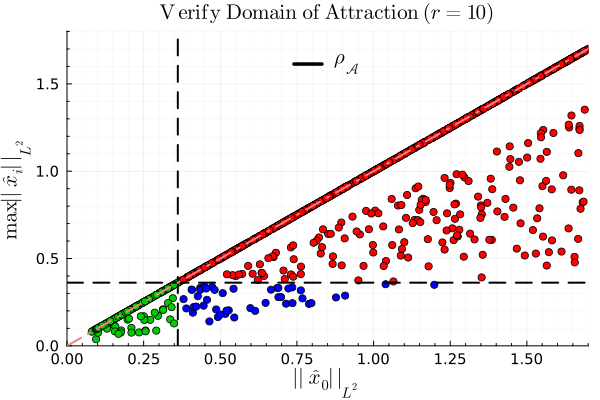

In [59]:
# Intrusive
p_test1_int = verify_DoA(ρ_min_res["int"][i], Ai, Fi, Vr, train_ic[:test1], train_wave; max_iter=10000, xticks=0:0.25:1.5, xlim=(0, 1.7), ρ_factor=5)

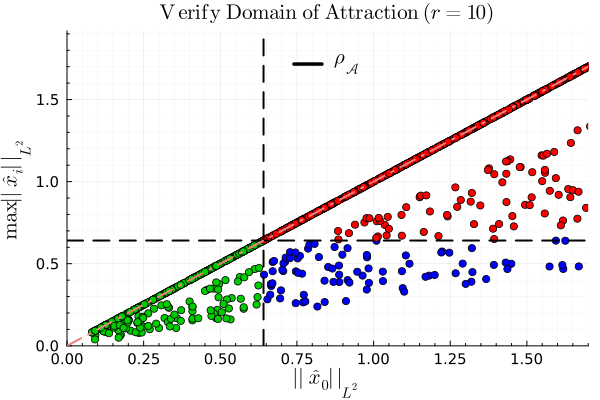

In [60]:
# OpInf
p_test1_inf = verify_DoA(ρ_min_res["inf"][i], Ai, Fi, Vr, train_ic[:test1], train_wave; max_iter=10000, xticks=0:0.25:1.5, xlim=(0, 1.7))

#### Test 2

$$
\begin{gather*}
    x(\omega, 0) = a\exp(-b\cos^2(\pi x+c)) - d
\end{gather*}
$$

where $a, b, c, d$ are the four parameters to adjust.

In [62]:
test2_params = (
    [0.0, 1.0],
    [0, 50],
    [0, 1.0],
    [0, 1]
)

test2_wave = (a,b,c,d) -> a*exp.(-b * cos.(π .* burger.x .+ c).^2) .- d
;

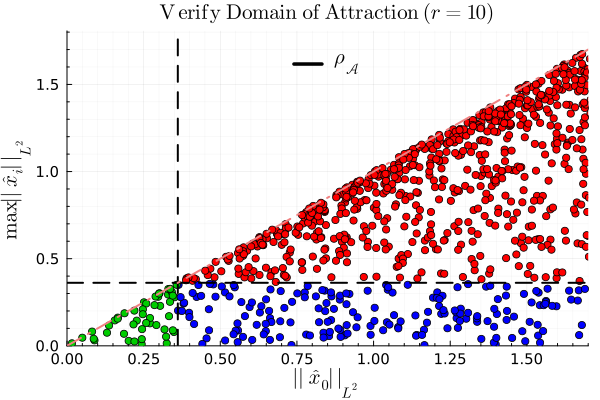

In [63]:
# Intrusive
p_test2_int = verify_DoA(ρ_min_res["int"][i], Ai, Fi, Vr, test2_params, test2_wave; max_iter=10000, xticks=0:0.25:1.5, xlim=(0, 1.7), ρ_factor=5)

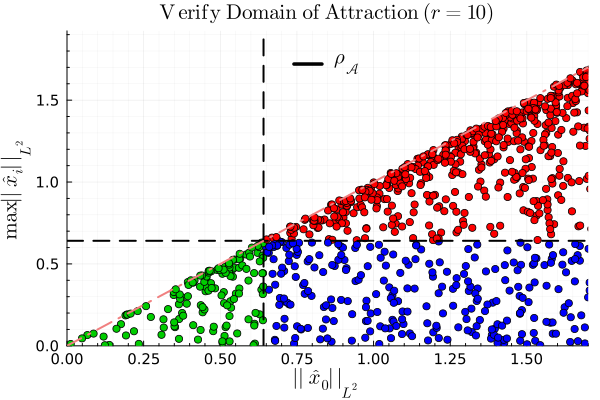

In [64]:
# OpInf
p_test2_inf = verify_DoA(ρ_min_res["inf"][i], Ai, Fi, Vr, test2_params, test2_wave; max_iter=10000, xticks=0:0.25:1.5, xlim=(0, 1.7))

#### Test 3

For Test 3, we use a complex wave with a combination of exponential, cosine, and sine waves.

$$
\begin{gather*}
    x(\omega, 0) = a\exp\left(-b\cos^2(\pi\omega) + c\sin^2\left(4\pi\omega+\frac{\pi}{3}\right)+ d\cos^2(3\pi\omega) \right)
\end{gather*}
$$

where $a, b, c, d$ are the three parameters to adjust.

In [65]:
# Parameters for the initial condition
test3_params = (
    [0.0, 1.0],
    [0, 50],
    [0, 1],
    [10, 30],
)

# Parameterized initial condition
test3_wave = (a,b,c,d) -> a * exp.(-b * cos.(π .* burger.x).^2 .+ c .* sin.(4*π .* burger.x .+ π/3).^2 .- d .* cos.(3*π .* burger.x).^2) 
;

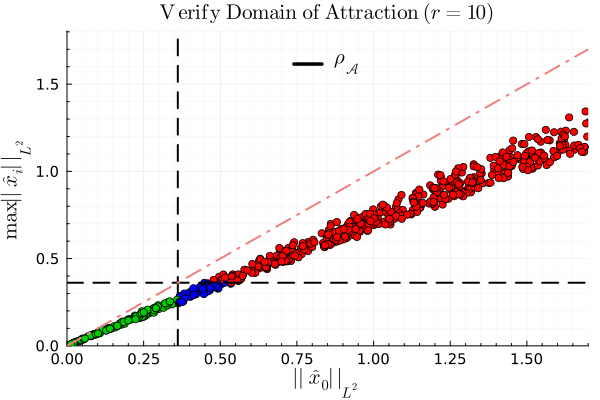

In [66]:
# Intrusive
p_test3_int = verify_DoA(ρ_min_res["int"][i], Ai, Fi, Vr, test3_params, test3_wave; max_iter=1000, xticks=0:0.25:1.5, xlim=(0, 1.7), ρ_factor=5)

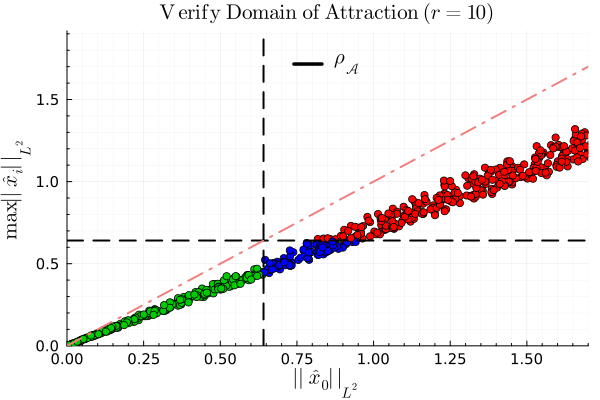

In [67]:
# OpInf
p_test3_inf = verify_DoA(ρ_min_res["inf"][i], Ai, Fi, Vr, test3_params, test3_wave; max_iter=1000, xticks=0:0.25:1.5, xlim=(0, 1.7))

## __OLD__

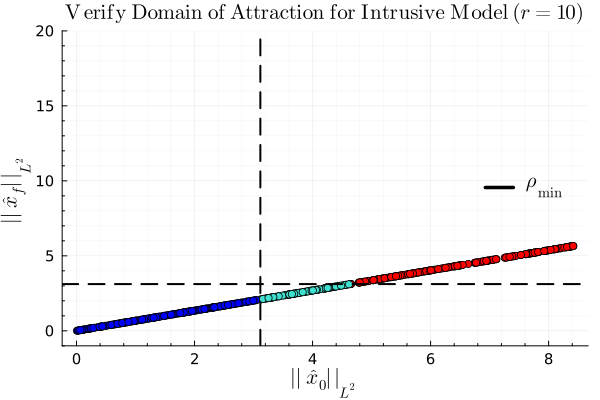

In [95]:
# The reduced dimension and the indices 
r = 10
i = r - rmin + 1  # index

# The system matrices for the intrusive model 
Ai = op_int.A[1:r,1:r]
Fi = LnL.extractF(op_int.F, r)

# Basis 
Vr = Vrmax[:,1:r]

# Get the computed domain of attraction for the intrusive model
ρ_min_i = ρ_min_res["int"][i]
ρ_max_i = ρ_max_res["int"][i]

# What is the max iteration for the Monte Carlo simulation
max_iter = 500

# Initialize the plot
p1 = plot()

for _ in 1:max_iter
    amp = rand(Uniform(0,1),1,1)[1]
    # ic_ = amp * burger.IC
    # ic_ = amp * (1 .- cos.(2π .* burger.x))
    ic_ = amp * (0.6*sin.(8π .* burger.x) - 0.5*cos.(2π .* burger.x) .+ 0.5)
    ic_norm = norm(ic_)

    states = burger.semiImplicitEuler(Ai, Fi, burger.t, Vr' * ic_)
    final_norm = norm(states[:,end], 2)
    
    # Check if the final states stays within the domain of attraction
    if ic_norm < ρ_min_i && final_norm < ρ_min_i
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:blue, label="")
    elseif ic_norm > ρ_min_i &&  final_norm < ρ_min_i
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:turquoise, label="")
    elseif ic_norm < ρ_min_i &&  final_norm > ρ_min_i
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:salmon, label="")
    else
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:red, label="")
    end
end
vline!(p1, [ρ_min_i], color=:black, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{min}}")
hline!(p1, [ρ_min_i], color=:black, linestyle=:dash, linewidth=2, label="")
xlabel!(L"||\hat{x}_0||_{L^2}")
ylabel!(L"||\hat{x}_f||_{L^2}")
ylims!(p1, (-1, 20))
plot!(majorgrid=true, minorgrid=true, legend=:right, legendfontsize=14, guidefontsize=14, tickfontsize=10, 
        fg_legend = :transparent, background_color_legend = :transparent)
title!(latexstring("\$\\mathrm{Verify~Domain~of~Attraction~for~Intrusive~Model~} (r=$r)\$"), textsize=4)

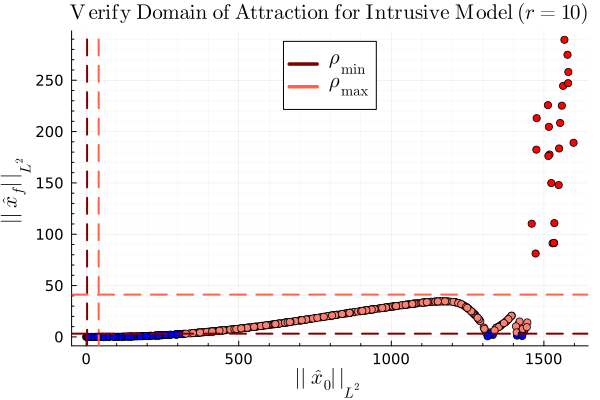

In [29]:
# The reduced dimension and the indices 
r = 10
i = r - rmin + 1  # index

# The system matrices for the intrusive model 
Ai = op_int.A[1:r,1:r]
Fi = LnL.extractF(op_int.F, r)

# Basis 
Vr = Vrmax[:,1:r]

# Get the computed domain of attraction for the intrusive model
ρ_min_i = ρ_min_res["int"][i]
ρ_max_i = ρ_max_res["int"][i]

# What is the max iteration for the Monte Carlo simulation
max_iter = 500

# TODO: Change the initial condition here
# burger.IC = 

# Initialize the plot
p1 = plot()

for _ in 1:max_iter
    amp = rand(Uniform(0,200),1,1)[1]
    ic_ = amp * burger.IC
    ic_norm = norm(ic_)

    states = burger.semiImplicitEuler(Ai, Fi, burger.t, Vr' * ic_)
    final_norm = norm(states[:,end], 2)
    
    # Check if the final states stays within the domain of attraction
    if final_norm < ρ_min_i
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:blue, label="")
    elseif final_norm < ρ_max_i
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:salmon, label="")
    else
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:red, label="")
    end
end
vline!(p1, [ρ_min_i], color=:maroon, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{min}}")
vline!(p1, [ρ_max_i], color=:tomato, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{max}}")
hline!(p1, [ρ_min_i], color=:maroon, linestyle=:dash, linewidth=2, label="")
hline!(p1, [ρ_max_i], color=:tomato, linestyle=:dash, linewidth=2, label="")
xlabel!(L"||\hat{x}_0||_{L^2}")
ylabel!(L"||\hat{x}_f||_{L^2}")
plot!(majorgrid=true, minorgrid=true, legend=:top, legendfontsize=14, guidefontsize=14, tickfontsize=10)
title!(latexstring("\$\\mathrm{Verify~Domain~of~Attraction~for~Intrusive~Model~} (r=$r)\$"), textsize=4)

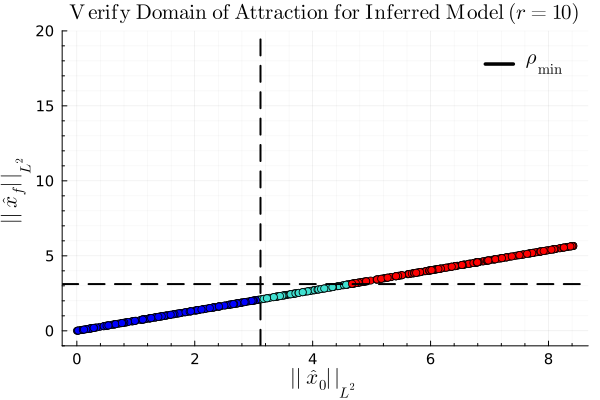

In [113]:
# The reduced dimension and the indices 
r = 10
i = r - rmin + 1  # index

# The system matrices for the OpInf model
Ao = op_LS.A[1:r,1:r]
Fo = LnL.extractF(op_LS.F, r)

# Basis 
Vr = Vrmax[:,1:r]

# Get the computed domain of attraction for the OpInf model
ρ_min_o = ρ_min_res["inf"][i]
ρ_max_o = ρ_max_res["inf"][i]

# What is the max iteration for the Monte Carlo simulation
max_iter = 500

# TODO: Change the initial condition here
# burger.IC = 

# Initialize the plot
p2 = plot()

for _ in 1:max_iter
    amp = rand(Uniform(0,1),1,1)[1]
    # ic_ = amp * burger.IC
    # ic_ = amp * (1 .- cos.(2π .* burger.x))
    ic_ = amp * (0.6*sin.(8π .* burger.x) - 0.5*cos.(2π .* burger.x) .+ 0.5)
    ic_norm = norm(ic_)

    ρ = ic_norm
    states = burger.semiImplicitEuler(Ao, Fo, burger.t, Vr' * ic_)
    final_norm = norm(states[:,end], 2)

    # Check if the final states stays within the domain of attraction
    if ic_norm < ρ_min_o && final_norm < ρ_min_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:blue, label="")
    elseif ic_norm > ρ_min_o &&  final_norm < ρ_min_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:turquoise, label="")
    elseif ic_norm < ρ_min_o &&  final_norm > ρ_min_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:salmon, label="")
    else
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:red, label="")
    end
end
vline!(p2, [ρ_min_o], color=:black, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{min}}")
hline!(p2, [ρ_min_o], color=:black, linestyle=:dash, linewidth=2, label="")
xlabel!(L"||\hat{x}_0||_{L^2}")
ylabel!(L"||\hat{x}_f||_{L^2}")
ylims!(p2, (-1, 20))
plot!(majorgrid=true, minorgrid=true, legend=:topright, legendfontsize=14, guidefontsize=14, tickfontsize=10, 
        fg_legend = :transparent, background_color_legend = :transparent)
title!(latexstring("\$\\mathrm{Verify~Domain~of~Attraction~for~Inferred~Model~} (r=$r)\$"), textsize=4)

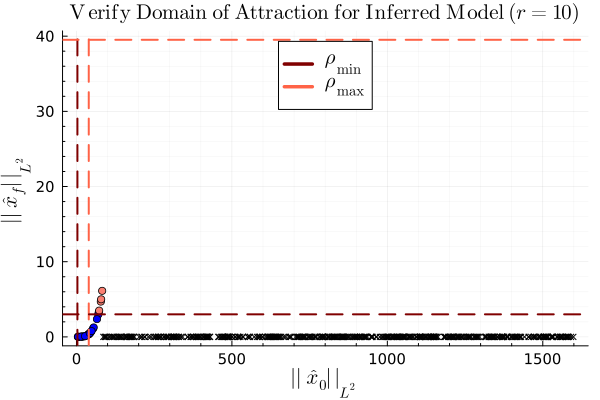

In [106]:
# The reduced dimension and the indices 
r = 10
i = r - rmin + 1  # index

# The system matrices for the OpInf model
Ao = op_LS.A[1:r,1:r]
Fo = LnL.extractF(op_LS.F, r)

# Basis 
Vr = Vrmax[:,1:r]

# Get the computed domain of attraction for the OpInf model
ρ_min_o = ρ_min_res["inf"][i]
ρ_max_o = ρ_max_res["inf"][i]

# What is the max iteration for the Monte Carlo simulation
max_iter = 500

# TODO: Change the initial condition here
# burger.IC = 

# Initialize the plot
p2 = plot()

for _ in 1:max_iter
    amp = rand(Uniform(0,200),1,1)[1]
    ic_ = amp * burger.IC
    ic_norm = norm(ic_)

    ρ = ic_norm
    states = burger.semiImplicitEuler(Ao, Fo, burger.t, Vr' * ic_)
    final_norm = norm(states[:,end], 2)

    # Check if the final states stays within the domain of attraction
    if final_norm < ρ_min_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:blue, label="")
    elseif final_norm < ρ_max_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:salmon, label="")
    elseif final_norm >= ρ_max_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:red, label="")
    elseif isnan(final_norm)
        scatter!(p2, [ic_norm], [0], marker=(:x, 3), color=:black, label="")
    end
end
vline!(p2, [ρ_min_o], color=:maroon, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{min}}")
vline!(p2, [ρ_max_o], color=:tomato, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{max}}")
hline!(p2, [ρ_min_o], color=:maroon, linestyle=:dash, linewidth=2, label="")
hline!(p2, [ρ_max_o], color=:tomato, linestyle=:dash, linewidth=2, label="")
xlabel!(L"||\hat{x}_0||_{L^2}")
ylabel!(L"||\hat{x}_f||_{L^2}")
plot!(majorgrid=true, minorgrid=true, legend=:top, legendfontsize=14, guidefontsize=14, tickfontsize=10)
title!(latexstring("\$\\mathrm{Verify~Domain~of~Attraction~for~Inferred~Model~} (r=$r)\$"), textsize=4)

### Analytical solution of $P$ when $Q$ is given

In [28]:
Ai = op_int.A
Fi = op_int.F

# Get the basis and the data matrix
r = size(Ai,1) 
Vr = Vrmax[:,1:r]
Xr = X' * Vr
Xr2 = LnL.squareMatStates(Xr')'

Q = 0.1I(r)

R = -0.5 * vec(Xr * Q' * Xr')
U = kron(Xr, Xr * Ai')
V = kron(Xr, Xr2 * Fi')
W = 0.25 * kron(Xr * Q * Xr' * Xr, Xr)
UVW = U + V - W
S = LnL.invec(UVW \ R, r, r)

10×10 Matrix{Float64}:
  0.00248682    -0.000794527  -3.12748e-5  …   1.19362e-8    4.41249e-10
 -0.000106592    0.00146793    0.00010948     -1.9572e-8    -6.15711e-10
  0.00119891    -0.234119     -0.008264        3.00081e-6    1.04242e-7
  0.0164905    -10.9778       -0.491598        0.000158525   5.92042e-6
  0.0446703     -0.539644      0.0495385      -5.11459e-6    5.87274e-7
  0.286451      -2.00551       0.355798    …  -5.79654e-5   -4.48512e-6
 -0.135957       0.407312     -0.180467       -4.96663e-5   -3.27628e-5
 -0.515016       0.773998     -0.984208        1.19847e-5    1.58293e-5
  0.123569      -0.685755     -0.156085        0.000101669  -6.92736e-6
 -0.169195       0.204841     -0.24968        -0.000158489  -2.23689e-5

In [ ]:
# ATTENTION: This is unsolvable due to singular matrix
P = 2 * LnL.invec( (1.0I(r*r) + LnL.commat(r,r)) \ vec(S), r, r)

### Recursive method

In [300]:
function demo_data(d, b)
    n = b^d
    c = zeros(n)
    f = collect(range(1, stop=d))
    a = []

    while true
        a = vector_next(d, b, a)
        if isempty(a)
            break
        end

        i = vector_rank(d, b, a)
        c[i] = dot(f, a)
    end

    return c
end

function vector_next(d, b, a, more)
    if !more
        append!(a, ones(d))
        more = true
    else
        for i in d:-1:1
            a[i] += 1
            if a[i] <= b
                return a, more
            end
            a[i] = 1
        end
        more = false
    end
    return a, more
end

function vector_next_equivalent(a)
    more = true
    n = length(a)
    i = n - 1

    while true
        if i <= 0
            break
        end

        if a[i] < a[i+1]
            break
        end

        i -= 1
    end

    if i == 0
        a = []
        more = false
    else
        j = n
        while a[j] <= a[i]
            j -= 1
        end

        t = a[i]
        a[i] = a[j]
        a[j] = t
        a[i+1:n] = reverse(a[i+1:n])
    end

    return a, more
end

function vector_next_representative(d, b, a, more)
    if !more
        append!(a, ones(d))
        more = true
    else
        for i in d:-1:1
            a[i] += 1
            if a[i] <= b
                a[i+1:d] .= a[i]
                return a, more
            end
        end
        more = false
    end
    return a, more
end

function vector_rank(d, b, a)
    rank = -1

    for i in 1:d
        if a[i] < 1 || a[i] > b
            return Int(rank)
        end
    end

    rank = 0
    for i in 1:d
        rank = b * rank + a[i]
    end

    rank = 1
    range = 1
    for i in 1:d
        rank += (a[d+1-i] - 1) * range
        range *= b
    end

    return Int(rank)
end
;

In [302]:
function kronMonomialSymmetrize(c, b = 3, d = 3; verbose = false)
    n = b^d
    if isempty(c)
        c = demo_data(d, b)
    end

    if verbose
        println("Original data C:")
        a = []
        more = false
        i = 0
        while true
            a, more = vector_next(d, b, a, more)
            if !more
                break
            end
            i += 1
            println("  #$i  C=$(c[i]), $a")
        end
    end

    c2 = zeros(n)
    z = []
    more = false
    j = 0

    if verbose
        println("\nData gathered to representatives and averaged:")
        println()
    end

    while true
        z, more = vector_next_representative(d, b, z, more)
        if !more
            break
        end

        j += 1
        mult = 0
        a = deepcopy(z)
        more2 = false
        while true
            mult += 1
            i = vector_rank(d, b, a)
            c2[j] += c[i]
            a, more2 = vector_next_equivalent(a)
            if !more2
                break
            end
        end
        c2[j] /= mult

        if verbose
            println("  #$j  mult=$mult  C2=$(c2[j]), $z")
        end

        a = deepcopy(z)
        more2 = false
        while true
            i = vector_rank(d, b, a)
            c[i] = c2[j]
            a, more2 = vector_next_equivalent(a)
            if !more2
                break
            end
        end
    end
    if verbose
        println("\nSymmetric C:")
        a = []
        more = false
        i = 0
        while true
            a, more = vector_next(d, b, a, more)
            if !more
                break
            end
            i += 1
            println("  #$i  C=$(c[i]), $a")
        end
    end

    return c
end
;

In [437]:
function RAZSA_o3(operators, r, Q2)
    A = operators.A[1:r, 1:r]
    A2 = LnL.extractH(operators.H, r)

    n = size(A,1)

    # Solve for first iteration (k = 2)
    P2 = lyapc(A, Q2)
    p2 = vec(P2)

    # Solve for the second iteration (k = 3)
    p3_tilde = - (kron(A', kron(I(n), I(n))) + kron(I(n), kron(A', I(n))) + kron(I(n), kron(I(n), A'))) \ (kron(A2', I(n)) + kron(I(n), A2')) * p2

    # Symmetrize the coefficients
    p3 = kronMonomialSymmetrize(p3_tilde, n, 3)

    # Store coefficients for the Lyapunov function
    Ps = Vector{VecOrMat{Float64}}(undef, 2)
    Ps[1] = p2
    Ps[2] = p3

    return Ps, P2
end

function RAZSA_o3_doa(Ps)
    p2 = Ps[1]
    p3 = Ps[2]

    n = length(p2)
    r = Int(sqrt(n))

    function Vp(x)
        return p2' * kron(x[1:r], x[1:r]) + p3' * kron(x[1:r], kron(x[1:r], x[1:r]))
    end

    function dVp!(x)
        return (p2' * (kron(I(r), x[1:r]) + kron(x[1:r], I(r))) + 
        p3' * (kron(I(r), kron(x[1:r], x[1:r])) + kron(x[1:r], kron(I(r), x[1:r])) + kron(x[1:r], kron(x[1:r], I(r)))))
    end 

    lower = 0.0001 * ones(r)
    upper = 10 * ones(r)
    initial_x = ones(r)
    # Get minimum DoA
    min_results = Optim.optimize(Vp, lower, upper, initial_x, Fminbox(BFGS()); autodiff = :forward)
    ρ_min = minimum(min_results)

    function Vn(x)
        return -p2' * kron(x[1:r], x[1:r]) - p3' * kron(x[1:r], kron(x[1:r], x[1:r]))
    end

    function dVn!(x)
        return (-p2' * (kron(I(r), x[1:r]) + kron(x[1:r], I(r))) - 
        p3' * (kron(I(r), kron(x[1:r], x[1:r])) + kron(x[1:r], kron(I(r), x[1:r])) + kron(x[1:r], kron(x[1:r], I(r)))))
    end 

    # Get maximum DoA 
    initial_x = -ones(r)
    max_results  = Optim.optimize(Vn, -upper, -lower, initial_x, Fminbox(BFGS()); autodiff = :forward)
    ρ_max = -minimum(max_results)
    return ρ_min, ρ_max
end

RAZSA_o3_doa (generic function with 1 method)

In [438]:
P_res2 = Dict(
    "int"=> Vector{VecOrMat}(undef, rmax-rmin+1),
    "inf"=> Vector{VecOrMat}(undef, rmax-rmin+1)
)
ρ_max_res2 = Dict(
    "int"=> Vector{Float64}(undef, rmax-rmin+1),
    "inf"=> Vector{Float64}(undef, rmax-rmin+1)
)
ρ_min_res2 = Dict(
    "int"=> Vector{Float64}(undef, rmax-rmin+1),
    "inf"=> Vector{Float64}(undef, rmax-rmin+1)
)
;

In [439]:
for r in r_range
    i = r - rmin + 1  # index

    # Solve the PP-ZQLFI problem
    Q = Matrix(I(r))
    P, P2 = RAZSA_o3(op_int, r, Q)
    P_res2["int"][i] = P

    # Compute the DoA 
    # ρ_min_res2["int"][i], ρ_max_res2["int"][i] = RAZSA_o3_doa(P)
    ρ_min_res2["int"][i], ρ_max_res2["int"][i] = LnL.DoA(P2)
end

In [441]:
for r in r_range
    i = r - rmin + 1  # index

    # Solve the PP-ZQLFI problem
    Q = Matrix(I(r))
    P, P2 = RAZSA_o3(op_LS, r, Q)
    P_res2["inf"][i] = P

    # Compute the DoA 
    # ρ_min_res2["inf"][i], ρ_max_res2["inf"][i] = RAZSA_o3_doa(P)
    ρ_min_res2["inf"][i], ρ_max_res2["inf"][i] = LnL.DoA(P2)
end

#### Add the recursive results

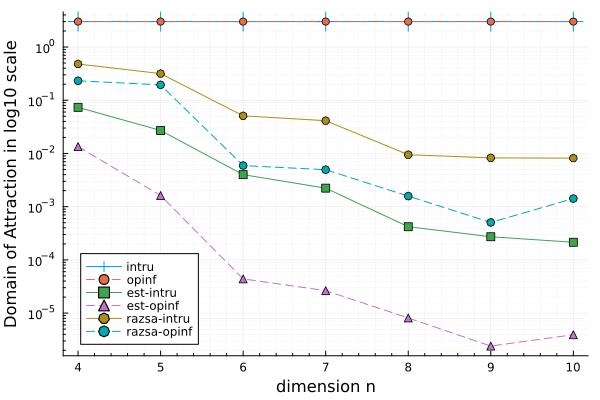

In [444]:
# domain of attraction
plot(r_range, ρ_min_res["int"], marker=(:cross, 10), label="intru")
plot!(r_range, ρ_min_res["inf"], marker=(:circle), ls=:dash, label="opinf")
plot!(r_range, ρ_est_res["int"], marker=(:rect), label="est-intru")
plot!(r_range, ρ_est_res["inf"], marker=(:utriangle), ls=:dash, label="est-opinf")
plot!(r_range, ρ_min_res2["int"], marker=(:heptagon), label="razsa-intru")
plot!(r_range, ρ_min_res2["inf"], marker=(:octagon), ls=:dash, label="razsa-opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomleft)
xticks!(r_range)
yticks!([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0])
xlabel!("dimension n")
ylabel!("Domain of Attraction in log10 scale")

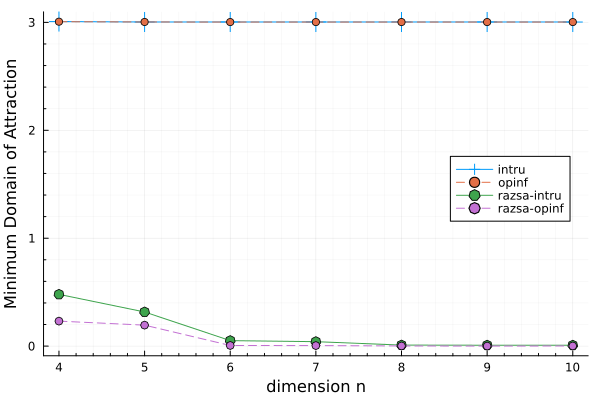

In [447]:
# domain of attraction
plot(r_range, ρ_min_res["int"], marker=(:cross, 10), label="intru")
plot!(r_range, ρ_min_res["inf"], marker=(:circle), ls=:dash, label="opinf")
plot!(r_range, ρ_min_res2["int"], marker=(:heptagon, 5), label="razsa-intru")
plot!(r_range, ρ_min_res2["inf"], marker=(:octagon), ls=:dash, label="razsa-opinf")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(r_range)
xlabel!("dimension n")
ylabel!("Minimum Domain of Attraction")

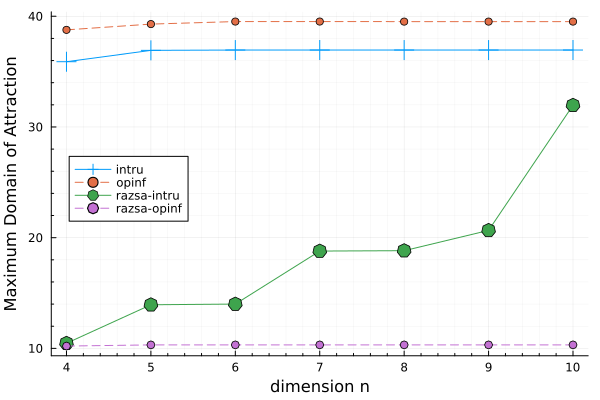

In [449]:
# Maximum domain of attraction
plot(r_range, ρ_max_res["int"], marker=(:cross, 10), label="intru")
plot!(r_range, ρ_max_res["inf"], marker=(:circle), ls=:dash, label="opinf")
plot!(r_range, ρ_max_res2["int"], marker=(:heptagon, 7), label="razsa-intru")
plot!(r_range, ρ_max_res2["inf"], marker=(:octagon), ls=:dash, label="razsa-opinf")
plot!(majorgrid=true, minorgrid=true, legend=:left)
xticks!(r_range)
xlabel!("dimension n")
ylabel!("Maximum Domain of Attraction")

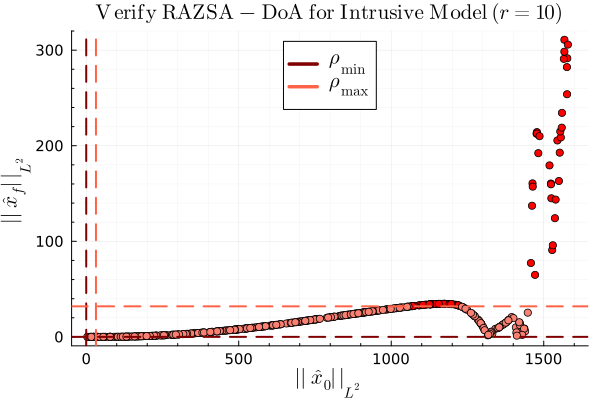

In [450]:
# The reduced dimension and the indices 
r = 10
i = r - rmin + 1  # index

# The system matrices for the intrusive model 
Ai = op_int.A[1:r,1:r]
Fi = LnL.extractF(op_int.F, r)

# Basis 
Vr = Vrmax[:,1:r]

# Get the computed domain of attraction for the intrusive model
ρ_min_i = ρ_min_res2["int"][i]
ρ_max_i = ρ_max_res2["int"][i]

# What is the max iteration for the Monte Carlo simulation
max_iter = 500

# TODO: Change the initial condition here
# burger.IC = 

# Initialize the plot
p1 = plot()

for _ in 1:max_iter
    amp = rand(Uniform(0,200),1,1)[1]
    ic_ = amp * burger.IC
    ic_norm = norm(ic_)

    states = burger.semiImplicitEuler(Ai, Fi, burger.t, Vr' * ic_)
    final_norm = norm(states[:,end], 2)
    
    # Check if the final states stays within the domain of attraction
    if final_norm < ρ_min_i
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:blue, label="")
    elseif final_norm < ρ_max_i
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:salmon, label="")
    else
        scatter!(p1, [ic_norm], [final_norm], marker=(:circle, 4), color=:red, label="")
    end
end
vline!(p1, [ρ_min_i], color=:maroon, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{min}}")
vline!(p1, [ρ_max_i], color=:tomato, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{max}}")
hline!(p1, [ρ_min_i], color=:maroon, linestyle=:dash, linewidth=2, label="")
hline!(p1, [ρ_max_i], color=:tomato, linestyle=:dash, linewidth=2, label="")
xlabel!(L"||\hat{x}_0||_{L^2}")
ylabel!(L"||\hat{x}_f||_{L^2}")
plot!(majorgrid=true, minorgrid=true, legend=:top, legendfontsize=14, guidefontsize=14, tickfontsize=10)
title!(latexstring("\$\\mathrm{Verify~RAZSA-DoA~for~Intrusive~Model~} (r=$r)\$"), textsize=4)

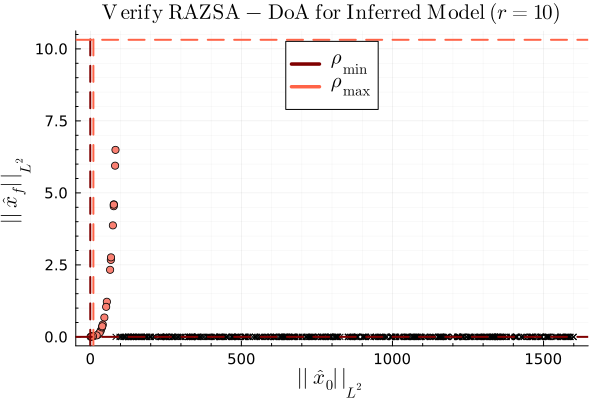

In [452]:
# The reduced dimension and the indices 
r = 10
i = r - rmin + 1  # index

# The system matrices for the OpInf model
Ao = op_LS.A[1:r,1:r]
Fo = LnL.extractF(op_LS.F, r)

# Basis 
Vr = Vrmax[:,1:r]

# Get the computed domain of attraction for the OpInf model
ρ_min_o = ρ_min_res2["inf"][i]
ρ_max_o = ρ_max_res2["inf"][i]

# What is the max iteration for the Monte Carlo simulation
max_iter = 500

# TODO: Change the initial condition here
# burger.IC = 

# Initialize the plot
p2 = plot()

for _ in 1:max_iter
    amp = rand(Uniform(0,200),1,1)[1]
    ic_ = amp * burger.IC
    ic_norm = norm(ic_)

    ρ = ic_norm
    states = burger.semiImplicitEuler(Ao, Fo, burger.t, Vr' * ic_)
    final_norm = norm(states[:,end], 2)

    # Check if the final states stays within the domain of attraction
    if final_norm < ρ_min_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:blue, label="")
    elseif final_norm < ρ_max_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:salmon, label="")
    elseif final_norm >= ρ_max_o
        scatter!(p2, [ic_norm], [final_norm], marker=(:circle, 4), color=:red, label="")
    elseif isnan(final_norm)
        scatter!(p2, [ic_norm], [0], marker=(:x, 3), color=:black, label="")
    end
end
vline!(p2, [ρ_min_o], color=:maroon, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{min}}")
vline!(p2, [ρ_max_o], color=:tomato, linestyle=:dash, linewidth=2, label=L"ρ_{\mathrm{max}}")
hline!(p2, [ρ_min_o], color=:maroon, linestyle=:dash, linewidth=2, label="")
hline!(p2, [ρ_max_o], color=:tomato, linestyle=:dash, linewidth=2, label="")
xlabel!(L"||\hat{x}_0||_{L^2}")
ylabel!(L"||\hat{x}_f||_{L^2}")
plot!(majorgrid=true, minorgrid=true, legend=:top, legendfontsize=14, guidefontsize=14, tickfontsize=10)
title!(latexstring("\$\\mathrm{Verify~RAZSA-DoA~for~Inferred~Model~} (r=$r)\$"), textsize=4)